In [56]:
%matplotlib inline
from utils import *
from pycaret.regression import*

In [57]:
def get_data(dataset_name, file_names_range, target, features, win_size=None, step_size_ratio=1):
    
    dataset_df = pd.DataFrame()        
    for n in file_names_range:        
        file_path = get_dataset_file_path(dataset_name, 'record_'+"{0:0=2d}".format(n)) 
        data = pd.read_pickle( file_path )  
        target_df = data.filter(regex=target, axis=1)
        features_df = data.filter(regex=features, axis=1)

        if win_size is not None:
            data_df = pd.DataFrame()    
            step_size = int(step_size_ratio * win_size)
                
            for i in range(0, len(features_df)- win_size, step_size):
                row = { target: target_df.loc[i+win_size-1, target]}
                
                for feature_name in features_df.columns: 
                    for j in range(win_size):
                        row.update({ feature_name + "{0:0=2d}".format(j): features_df.loc[i+j, feature_name] })
                data_df = data_df.append(row, ignore_index=True)
        else:
            data_df = pd.concat([features_df, target_df], axis=1)
        
        dataset_df = dataset_df.append(data_df, ignore_index=True)
    
    dataset_df = dataset_df.rename({target:'target'}, axis=1)
    return dataset_df

# Data

#### Load Data

In [61]:
dataset_name = 'dataset_02' 
target = 'distance_1' 
features = 'rssi' 
win_size = 20
step_size_ratio = 20

# Tarining
file_names_range = np.arange(25)
data = get_data( dataset_name, file_names_range, target, features, win_size=win_size, step_size_ratio=step_size_ratio )

# Test
file_names_range = np.arange(25,30)
data_unseen = get_data( dataset_name, file_names_range, target, features, win_size=win_size, step_size_ratio=step_size_ratio )

display(data)

,target,rssi_000,rssi_001,rssi_002,rssi_003,rssi_004,rssi_005,rssi_006,rssi_007,rssi_008,...,rssi_110,rssi_111,rssi_112,rssi_113,rssi_114,rssi_115,rssi_116,rssi_117,rssi_118,rssi_119
0,0.312323,142.636364,142.636364,142.636364,142.636364,142.636364,142.636364,142.636364,142.636364,142.636364,...,143.545455,143.636364,143.727273,143.818182,143.909091,144.000000,144.000000,144.000000,144.000000,144.000000
1,0.368384,132.727273,132.181818,131.181818,130.090909,128.909091,127.909091,126.818182,125.636364,124.454545,...,139.272727,139.090909,138.909091,138.727273,138.636364,138.545455,138.454545,138.363636,138.272727,138.181818
2,0.276445,138.272727,138.272727,138.272727,138.272727,138.272727,138.272727,138.272727,138.272727,138.272727,...,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,142.909091,142.818182
3,0.355647,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,139.909091,139.818182,...,143.454545,143.363636,143.272727,143.181818,143.090909,143.000000,142.909091,142.818182,142.727273,142.636364
4,0.442537,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,...,113.181818,112.818182,112.454545,112.090909,111.545455,110.454545,109.272727,107.909091,107.272727,106.727273
5,0.511911,142.363636,142.454545,142.545455,142.636364,142.727273,142.818182,142.909091,143.000000,143.000000,...,131.000000,131.363636,131.727273,132.000000,132.272727,132.363636,132.454545,132.454545,132.454545,132.454545
6,0.356415,147.181818,147.181818,147.181818,147.181818,147.181818,147.181818,147.181818,147.181818,147.181818,...,106.545455,106.181818,105.727273,104.090909,102.454545,100.818182,101.454545,102.454545,103.454545,104.454545
7,0.429160,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,140.909091,...,130.727273,130.454545,130.181818,129.909091,129.636364,129.363636,129.090909,128.818182,128.727273,128.545455
8,0.324634,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,...,134.090909,133.909091,133.727273,133.545455,133.363636,133.272727,133.181818,133.000000,132.818182,132.636364
9,0.354862,116.545455,115.454545,113.727273,111.636364,109.636364,108.363636,107.909091,107.636364,107.090909,...,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,140.909091


# Regression

In [62]:
exp_reg = setup(data,
#                 train_size = .9,
                target = 'target', 
                normalize = True, 
                session_id = 20
                )   

 
Setup Succesfully Completed!


,Description,Value
0,session_id,20
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(47, 41)"
4,Missing Values,False
5,Numeric Features,40
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


#### Model

In [63]:
model = tune_model('lightgbm')
# model = create_model('rf')

NRMSE = round(exp_reg[-1][-1][-1].RMSE.Mean / np.mean(data.target) * 100, 2)
print(NRMSE)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0760,0.0062,0.0785,-0.7609,0.0592,0.2205
1,0.0675,0.0075,0.0868,-1.5335,0.0698,0.3579
2,0.1873,0.0355,0.1883,-0.0628,0.1470,1.0849
3,0.0726,0.0064,0.0800,-0.2214,0.0637,0.3279
4,0.1180,0.0167,0.1292,-0.0442,0.0986,0.4612
5,0.1354,0.0272,0.1649,-0.0395,0.1209,0.4623
6,0.0859,0.0093,0.0965,-0.0013,0.0732,0.2991
7,0.0716,0.0062,0.0784,-0.5632,0.0587,0.2021
8,0.1446,0.0226,0.1502,-0.0161,0.1151,0.6371
9,0.1055,0.0147,0.1211,-0.0069,0.0936,0.4518


37.42


In [10]:
# plot_model(model, plot='error')
# plot_model(model, plot='feature')

In [66]:
data_unseen

,target,rssi_000,rssi_001,rssi_002,rssi_003,rssi_004,rssi_005,rssi_006,rssi_007,rssi_008,...,rssi_110,rssi_111,rssi_112,rssi_113,rssi_114,rssi_115,rssi_116,rssi_117,rssi_118,rssi_119
0,0.121833,136.272727,136.272727,136.272727,136.272727,136.272727,136.272727,136.272727,136.272727,136.272727,...,140.818182,140.909091,141.000000,141.000000,141.000000,141.090909,141.181818,141.272727,141.363636,141.454545
1,0.357696,137.000000,137.181818,137.363636,137.545455,137.636364,137.727273,137.818182,137.909091,138.000000,...,140.545455,140.545455,140.545455,140.545455,140.545455,140.454545,140.363636,140.272727,140.090909,139.909091


#### Test

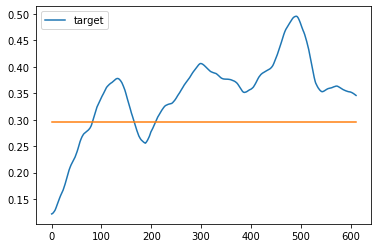

In [68]:
data_unseen = get_data( dataset_name, [25], target, features, win_size=win_size, step_size_ratio=1/20 )
prediction = predict_model(model, data=data_unseen)

window_length = 17
labels = prediction.Label
labels = labels.rolling(window_length, axis=0).mean()    # Smoothing
labels = labels.ffill(axis=0).bfill(axis=0)              # Gap Filling
    
ax = prediction.plot(y='target')
labels.plot(y='Label', ax=ax)
# data_unseen.plot(y='rssi_1')
plt.show()


In [ ]:
# save_experiment(get_result_file_path('res_00'))

#### Compare Regressors

In [60]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.049500,0.004000,0.063600,0.437400,0.048000,0.168100
1,CatBoost Regressor,0.050200,0.004100,0.064300,0.425100,0.048600,0.171100
2,K Neighbors Regressor,0.048900,0.004400,0.066700,0.382000,0.050300,0.164800
3,Extreme Gradient Boosting,0.053500,0.004600,0.068000,0.356600,0.051400,0.184000
4,Gradient Boosting Regressor,0.053400,0.004600,0.068000,0.356400,0.051400,0.183800
5,Random Forest,0.049400,0.004600,0.068100,0.354000,0.051400,0.165900
6,Support Vector Machine,0.057700,0.005200,0.072200,0.275400,0.054500,0.197900
7,AdaBoost Regressor,0.058300,0.005300,0.072500,0.268700,0.054700,0.199400
8,Extra Trees Regressor,0.052600,0.005300,0.073000,0.259100,0.055100,0.176700
9,Orthogonal Matching Pursuit,0.063000,0.006000,0.077600,0.162600,0.058600,0.217800


# sklearn

In [ ]:
from sklearn import*
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [50]:
X_train = data.filter(regex='rssi', axis=1).to_numpy()
Y_train = data.filter(regex='target', axis=1).to_numpy()

model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model.fit(X_train, Y_train)



Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

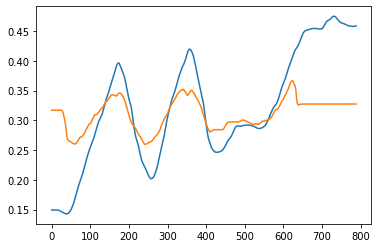

In [55]:
data_unseen = get_data( dataset_name, [29], target, features, win_size=win_size, step_size_ratio=step_size_ratio )

X_validation = data_unseen.filter(regex='rssi', axis=1).to_numpy()
Y_validation = data_unseen.filter(regex='target', axis=1).to_numpy()

predictions = model.predict( X_validation )  

plt.plot(Y_validation)
plt.plot(predictions)
plt.show()

#### Hyperparameter Tuning for Window-Sliding:

In [ ]:
def test(win_size, step_size_ratio)
    data = get_data(
        dataset_name = 'dataset_01', 
        file_names_range = np.arange(20), 
        target = 'distance_0', 
        features = 'rssi', 
        win_size = win_size, 
        step_size_ratio = step_size_ratio)

    exp_reg = setup(data, 
              target = 'target', 
              normalize = True, 
              session_id = 100)   

    model = tune_model('rf')
    model_rmse = exp_reg[9][8][1].RMSE.Mean
    return model_rmse

In [70]:
best_result = dict( win_size=None, step_size_ratio=None)
min_rmse = test(None, None)

for win_size in [10, 20]:
    for step_size_ratio in [.25, .5, .75, 1]:
        test(win_size, step_size_ratio)
        if model_rmse < min_rmse: best_result.update({'win_size':win_size, 'step_size_ratio':step_size_ratio})

print(best_result)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0403,0.0031,0.0554,0.5275,0.0387,0.0970
1,0.0491,0.0038,0.0620,0.5753,0.0456,0.1530
2,0.0483,0.0043,0.0656,0.2679,0.0471,0.1341
3,0.0483,0.0037,0.0606,0.5677,0.0433,0.1282
4,0.0497,0.0047,0.0683,0.4076,0.0498,0.1485
5,0.0486,0.0038,0.0617,0.4269,0.0443,0.1279
6,0.0336,0.0020,0.0452,0.7171,0.0317,0.0837
7,0.0497,0.0050,0.0704,0.4416,0.0491,0.1148
8,0.0374,0.0022,0.0469,0.6599,0.0324,0.0863
9,0.0418,0.0028,0.0525,0.5632,0.0377,0.1116
